In [1]:
from datasets import load_dataset,Dataset
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd 
pd.set_option("display.max_colwidth", None)

In [2]:
ds = load_dataset("imdb")

In [3]:
# description of class labels in dataset
ds["train"].features

{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

In [4]:
ds["train"][2]

{'text': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
 'label': 0}

In [5]:
df_train = ds["train"].to_pandas()
df_test = ds["test"].to_pandas()

In [6]:
df_train.shape

(25000, 2)

In [7]:
# check the assigned unique class labels in the dataset 
df_train.label.unique()

array([0, 1])

In [8]:
# check for class balance in the given dataset 
df_train.label.value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

In [9]:
df_train["text_len"] = df_train["text"].apply(lambda x : len(x))

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


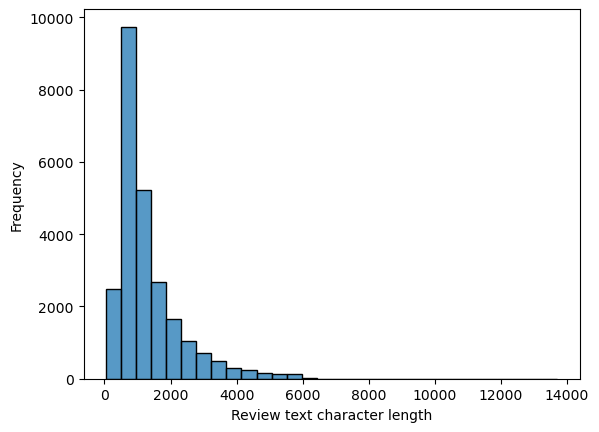

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_train, x="text_len", bins=30, kde=False)

plt.xlabel("Review text character length")
plt.ylabel("Frequency")
plt.show()

In [11]:
# text cleanup
df_train["text"] = df_train["text"].str.lower()
df_train["text"] = df_train["text"].str.replace(r"\s+", " ", regex = True).str.strip().str.replace("<br />", "")

In [12]:
text_list = df_train["text"].tolist()
text_list[:3]

['i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u.s. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" i really had to see this for myself.the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.what kills me about i am curious-yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then it\'s not shot 

In [13]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [20]:
def tokenize(batch):
    return tokenizer(
        batch["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=256
    )

enc_ds = ds.map(tokenize, batched=True)
enc_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [21]:
# add classification head to fine-tune BERT model 
clf = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)
clf.gradient_checkpointing_enable()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
print(clf)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [26]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support


# set training parameters 
args = TrainingArguments(
    output_dir="./bert_result",
     eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1"   
)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# create trainer instance for training BERT model on imdb data 
trainer = Trainer(
    model=clf,
    args=args,
    train_dataset=enc_ds["train"],
    eval_dataset=enc_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics

)

/var/folders/yd/c6pqg7cn1zg9lxy5vkyf64fm0000gn/T/ipykernel_44363/2071512194.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [27]:
torch.mps.empty_cache()

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.295800,0.302166,0.898504,0.894720,0.894470
2,0.195200,0.357872,0.911122,0.910920,0.910909
3,0.099100,0.424570,0.911543,0.911520,0.911519


/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=9375, training_loss=0.20829040649414063, metrics={'train_runtime': 73820.1362, 'train_samples_per_second': 1.016, 'train_steps_per_second': 0.127, 'total_flos': 4967527449600000.0, 'train_loss': 0.20829040649414063, 'epoch': 3.0})

In [29]:
results = trainer.evaluate()
print(results)

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.4245699644088745, 'eval_precision': 0.9115432729367018, 'eval_recall': 0.91152, 'eval_f1': 0.9115187490874671, 'eval_runtime': 464.7817, 'eval_samples_per_second': 53.789, 'eval_steps_per_second': 6.724, 'epoch': 3.0}
